All the necessary modules are imported:

In [1]:
import scipy.io
import glob
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import math

Data manipulation and import functions:

In [2]:
def get_data(train_or_validation):
    folder_path = 'CoordinateData/' + train_or_validation + '/'
    start_int = 0 
    data = []
    if train_or_validation == 'train':
        start_int = 21
    elif train_or_validation == 'validation':
        start_int = 26
    for filename in glob.glob(os.path.join(folder_path, '*.mat')):
        with open(filename, 'r'):
            this_fp = folder_path + filename[start_int: len(filename)]
            this_dat = scipy.io.loadmat(this_fp)
            data.append(this_dat)
    return data

def split_data(d_):
    x_ = []
    y_ = []
    for i in range(len(d_)):
        x_.append(d_[i]['data'][:, 0:71])
        y_.append(d_[i]['data'][:, 72])
    data_return = {
        "x": x_,
        "y": y_
    }
    return data_return

def normalise_data(t_datas, val_datas):
    arr = t_datas["x"][0]
    for k in range(1, len(t_datas["x"])):
        arr = np.concatenate((arr, t_datas["x"][k]), axis=0)
    for j in range(len(val_datas["x"])):
        arr = np.concatenate((arr, val_datas["x"][j]), axis=0)
    norms = []
    for m in range(arr.shape[1]):
        norm = np.linalg.norm(arr[:, m])
        norms.append(norm)
    
    for k in range(len(t_datas["x"])):
        for a in range(len(norms)):
            t_datas["x"][k][:, a] = t_datas["x"][k][:, a] / norms[a]
    
    for j in range(len(val_datas["x"])):
        for p in range(len(norms)):
            val_datas["x"][j][:, p] = val_datas["x"][j][:, p] / norms[p]
    
    return t_datas, val_datas

def get_training_instance(timesteps, train_batch):
    idx = random.randint(0, len(train_batch["x"])-1)
    length = train_batch["x"][idx].shape[0]
    max_idx = (length - (timesteps+1))
    second_idx = random.randint(0, max_idx)
    x_batch = train_batch["x"][idx][second_idx:second_idx+timesteps, :]
    y_batch = train_batch["y"][idx][second_idx:second_idx+timesteps]
    x_batch = x_batch.reshape(x_batch.shape[0]*x_batch.shape[1], 1)
    y_batch = y_batch[timesteps-1]
    training_instance = {
        "x": x_batch,
        "y": y_batch
    }
    return training_instance

def create_dataset(timesteps, num_samples, training_data):
    n, m = get_training_instance(timesteps, training_data)["x"].shape
    x_data = np.zeros((num_samples, n))
    y_data = np.zeros((num_samples,))
    for i in range(num_samples):
        inst = get_training_instance(timesteps, training_data)
        x = inst["x"]
        y = inst["y"]
        x_data[i, :] = x.transpose()
        y_data[i] = y
    return x_data, y_data


Function for creating the model with Keras:

In [3]:
def make_model(samp, act):
    model = Sequential()
    n, m = samp["x"].shape
    model.add(Dense(round(n*0.85), input_shape=(n,), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(round(n*0.5), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(round(n*0.3), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(round(n*0.15), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    opt = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
    return model

Utilising the above functions:

In [4]:
training_datas = get_data("train")
validation_datas = get_data("validation")

In [5]:
training_data = split_data(training_datas)
validation_data = split_data(validation_datas)
training_data, validation_data = normalise_data(training_data, validation_data)

Building and testing the model with different activation functions and number of timesteps:

In [6]:
%%capture
activations = ["sigmoid", "relu", "tanh", "elu", "selu", "softsign"]
samps = 10_000
tts = 0.3
results = []
num_res = []

for step in range(1, 20):
    X, Y = create_dataset(step, samps, training_data)
    X_vali, Y_vali = create_dataset(step, round((samps / ((1 - tts) * 10)) * 10), validation_data)
    for i in range(len(activations)):
        buffered_MLP = make_model(get_training_instance(step, training_data), activations[i])
        buffered_MLP.fit(X, Y, epochs=10)
        history = buffered_MLP.evaluate(X_vali, Y_vali)
        num_res.append([samps, round((samps + samps*tts) - samps), step, activations[i], float(history[0]), float(history[1])])
        eee = ("Training set size: " + str(samps)  + 
               "\nValidation set size: " + str(round((samps + samps*tts) - samps)) +  
               "\nNum timesteps: " + str(step) + 
               "\nActivation function: " + activations[i]
               + "\nValidation Loss: " + str(history[0]) + 
               "\nValidation Accuracy: " + str(history[1]) + "\n\n")
        results.append(eee)

Processing the results to find the best hyperparameters:

In [7]:
numerical_results = np.asarray(num_res)

losses = numerical_results[:, 4]
losses = losses.astype(np.float)
accuracies = numerical_results[:, 5]
accuracies = accuracies.astype(np.float)

numerical_results[:, 4] = losses
numerical_results[:, 5] = accuracies

idx = np.where(losses == np.amin(losses))
idx2 = np.where(accuracies == np.amax(accuracies))
params = numerical_results[idx2, :]

last_idx = list(params[0,:,4]).index(min(list(params[0, :, 4])))

final_params = params[0, last_idx, :]

In [8]:
print(final_params)

['10000' '3000' '7' 'tanh' '0.05155140906572342' '0.945681095123291']


Making a new model based on the best hyperparameters found prior, and training it on a much larger dataset, then testing it on 100 randomly selected datasets from the validation dataset:

In [9]:
%%capture
activation = final_params[3]
samps = 100_000
tts = 0.3
final_losses = []
final_accuracies = []

step = int(final_params[2])

X, Y = create_dataset(step, samps, training_data)
final_mlp = make_model(get_training_instance(step, training_data), activation)
final_mlp.fit(X, Y, epochs=10)

evaluation_epochs = 100

for i in range(evaluation_epochs):
    X_vali, Y_vali = create_dataset(step, round((samps / ((1 - tts) * 10)) * 10), validation_data)
    history = final_mlp.evaluate(X_vali, Y_vali)
    final_losses.append(history[0])
    final_accuracies.append(history[1])

Plotting the results:

In [10]:
for i in range(len(final_accuracies)):
    final_accuracies[i] = final_accuracies[i] * 100

Text(0.5, 0, 'Dataset number')

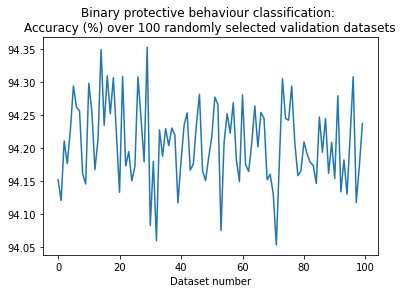

In [11]:
plt.plot(final_accuracies)
plt.title("Binary protective behaviour classification: \nAccuracy (%) over 100 randomly selected validation datasets")
plt.xlabel("Dataset number")

Text(0, 0.5, 'Loss value')

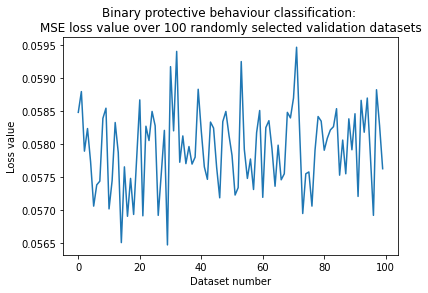

In [12]:
plt.plot(final_losses)
plt.title("Binary protective behaviour classification: \nMSE loss value over 100 randomly selected validation datasets")
plt.xlabel("Dataset number")
plt.ylabel("Loss value")

In [13]:
print("Average accuracy over 100 randomly generated validation datasets: \t" 
      + str(sum(final_accuracies) / len(final_accuracies)) + 
      "%\nAverage loss over 100 randomly generated validation datasets: \t\t"
     + str(sum(final_losses) / len(final_losses)))

Average accuracy over 100 randomly generated validation datasets: 	94.20645147562027%
Average loss over 100 randomly generated validation datasets: 		0.0579354877397418


Multiclass predictive behaviour type classification:

In [14]:
def make_multiclass_model(samp, act):
    model = Sequential()
    n, m = samp["x"].shape
    model.add(Dense(round(n*0.85), input_shape=(n,), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(round(n*0.5), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(round(n*0.3), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(round(n*0.15), activation=act))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation="sigmoid"))
    opt = tf.keras.optimizers.Adam(lr=0.1)
    model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
    return model

Near enough the same model architecture is used as in the binary classifier, except the output dimension is 4 rather than 5. 

Similar data processing functions as in the last section are declared:

In [15]:
def split_data_multiclass(d_):
    x_ = []
    y_ = []
    for i in range(len(d_)):
        x_.append(d_[i]['data'][:, 0:71])
        y_.append(d_[i]['data'][:, 73:-1])
    data_return = {
        "x": x_,
        "y": y_
    }
    return data_return

def create_dataset_multiclass(timesteps, num_samples, training_data):
    n, m = get_training_instance(timesteps, training_data)["x"].shape
    j = get_training_instance(timesteps, training_data)["y"].shape
    x_data = np.zeros((num_samples, n))
    y_data = np.zeros((num_samples, j[0]))
    for i in range(num_samples):
        inst = get_training_instance(timesteps, training_data)
        x = inst["x"]
        y = inst["y"]
        x_data[i, :] = x.transpose()
        y_data[i, :] = y
    return x_data, y_data

Utilising the above functions:

In [16]:
training_datas = get_data("train")
validation_datas = get_data("validation")
training_data_multiclass = split_data_multiclass(training_datas)
validation_data_multiclass = split_data_multiclass(validation_datas)

In [17]:
training_data_multiclass, validation_data_multiclass = normalise_data(training_data_multiclass, validation_data_multiclass)

Testing all the hyperparameters similar to in the section above:

In [18]:
%%capture
samps = 10_000
tts = 0.3
results = []
num_res = []
activations = ["sigmoid", "relu", "tanh", "elu", "selu", "softsign"]

for step in range(1, 20):
    X, Y = create_dataset_multiclass(step, samps, training_data_multiclass)
    X_vali, Y_vali = create_dataset_multiclass(step, round((samps + samps*tts) - samps), validation_data_multiclass)
    for i in range(len(activations)):
        buffered_MLP = make_multiclass_model(get_training_instance(step, training_data_multiclass), activations[i])
        buffered_MLP.fit(X, Y, epochs=5)
        history = buffered_MLP.evaluate(X_vali, Y_vali)
        eee = ("Training set size: " + str(samps)  + 
           "\nValidation set size: " + str(round((samps + samps*tts) - samps)) +  
           "\nNum timesteps: " + str(step) + 
           "\nActivation function: " + activations[i]
           + "\nValidation Loss: " + str(history[0]) + 
           "\nValidation Accuracy: " + str(history[1]) + "\n\n")
        results.append(eee)
        num_res.append([samps, round((samps + samps*tts) - samps), step, activations[i], history[0], history[1]])

Acquiring the hyperparameters of the most successful model:

In [19]:
numerical_results = np.asarray(num_res)

losses = numerical_results[:, 4]
losses = losses.astype(np.float)
accuracies = numerical_results[:, 5]
accuracies = accuracies.astype(np.float)

numerical_results[:, 4] = losses
numerical_results[:, 5] = accuracies

idx = np.where(losses == np.amin(losses))
idx2 = np.where(accuracies == np.amax(accuracies))
params = numerical_results[idx2, :]

last_idx = list(params[0,:,4]).index(min(list(params[0, :, 4])))

final_params = params[0, last_idx, :]


In [20]:
print(final_params)

['10000' '3000' '1' 'softsign' '0.013266364112496376' '0.9896666407585144']


Creating a new model and training it on a much larger dataset with the optimal hyperparameters acquired above, then again evaluating that model on 100 randomly selected validation datasets:

In [21]:
%%capture
activation = final_params[3]
samps = 100_000
tts = 0.3
final_losses = []
final_accuracies = []

step = int(final_params[2])

X, Y = create_dataset_multiclass(step, samps, training_data_multiclass)
final_mlp = make_multiclass_model(get_training_instance(step, training_data_multiclass), activation)
final_mlp.fit(X, Y, epochs=10)

evaluation_epochs = 100

for i in range(evaluation_epochs):
    X_vali, Y_vali = create_dataset_multiclass(step, round((samps / ((1 - tts) * 10)) * 10), validation_data_multiclass)
    history = final_mlp.evaluate(X_vali, Y_vali)
    final_losses.append(history[0])
    final_accuracies.append(history[1])

Plotting the results:

In [22]:
for i in range(len(final_accuracies)):
    final_accuracies[i] = final_accuracies[i] * 100

Text(0.5, 0, 'Dataset number')

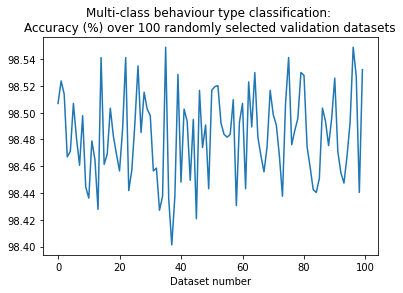

In [23]:
plt.plot(final_accuracies)
plt.title("Multi-class behaviour type classification: \nAccuracy (%) over 100 randomly selected validation datasets")
plt.xlabel("Dataset number")

Text(0, 0.5, 'Loss value')

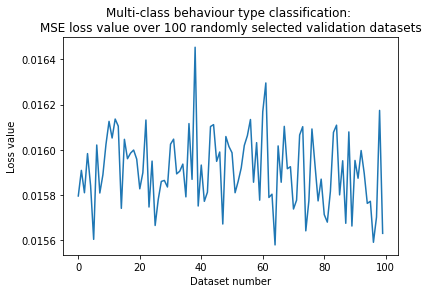

In [24]:
plt.plot(final_losses)
plt.title("Multi-class behaviour type classification: \nMSE loss value over 100 randomly selected validation datasets")
plt.xlabel("Dataset number")
plt.ylabel("Loss value")

In [25]:
print("Average accuracy over 100 randomly generated validation datasets: \t" 
      + str(sum(final_accuracies) / len(final_accuracies)) + 
      "%\nAverage loss over 100 randomly generated validation datasets: \t\t"
     + str(sum(final_losses) / len(final_losses)))

Average accuracy over 100 randomly generated validation datasets: 	98.48310548067093%
Average loss over 100 randomly generated validation datasets: 		0.01591218457557261
